In [1]:
# Linear Discriminant Analysis(LDA, 선형판별분석)
## 클래스를 최적으로 구분할 수 있는 특성 찾기
## PCA와 달리 지도 학습 알고리즘
## (가정 1) 데이터는 정규 분포
## (가정 2) 클래스는 동일한 공분한 행렬을 가지며 샘플은 통계적으로 독립적

# LDA 알고리즘 구현
# (1) d차원 데이터셋 전처리 - 표준화
# (2) 각 클래스에 대해 d차원 평균 벡터 계산
# (3) 클래스간 scatter matrix S_B와 클래스내 scatter martix S_w 구성
# (4) S_w^(-1)*S_B 행렬의 eigenvector, eigenvalue 계산
# (5) eigenvalue 내림차순 정렬
# (6) 가장 큰 eigenvalue k개를 선택하여 d*k차원의 변환행렬 W 구성 > W의 열이 고유 벡터
# (7) W를 사용해서 d차원 데이터 X를 k차원 특성으로 변환

In [4]:
# LDA 알고리즘 구현
# (0) 데이터 로드

import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

# (1) d차원 데이터셋 전처리 - 표준화
## test, train set으로 나누고 표준화 진행
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, stratify=y, random_state=0)
                      
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
# LDA 알고리즘 구현
# (2) 각 클래스에 대해 d차원 평균 벡터 계산
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [6]:
# LDA 알고리즘 구현
# (3) 클래스간 scatter matrix S_B와 클래스내 scatter martix S_w 구성
## (3-1) 클래스내 산포행렬 계산
d = 13 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

## (3-2) 클래스간 산포행렬 계산
## 클래스분포가 고르지 않기 때문에, 산포행렬보다 공분산행렬을 사용하는게 나음
## 산포행렬의 정규화(산포행렬을 클래스개수로 나눔) = 공분산행렬
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # 열 벡터로 만들기
d = 13  # 특성의 수
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 내의 산포 행렬: 13x13
클래스 간의 산포 행렬: 13x13


<function matplotlib.pyplot.show(*args, **kw)>

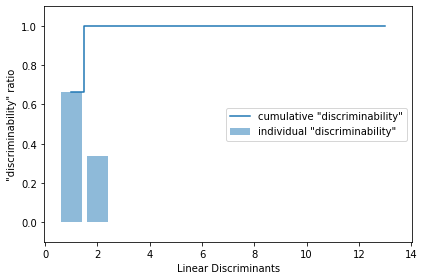

In [10]:
# LDA 알고리즘 구현
# (4) S_w^(-1)*S_B 행렬의 eigenvector, eigenvalue 계산
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# (5) eigenvalue 내림차순 정렬
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show

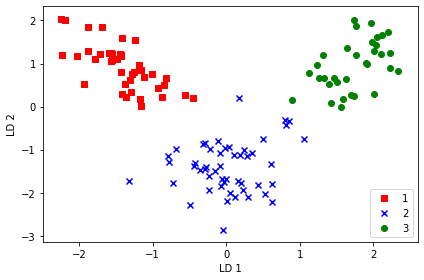

In [11]:
# LDA 알고리즘 구현
# (6) 가장 큰 eigenvalue k개를 선택하여 d*k차원의 변환행렬 W 구성 > W의 열이 고유 벡터
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

# (7) W를 사용해서 d차원 데이터 X를 k차원 특성으로 변환
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

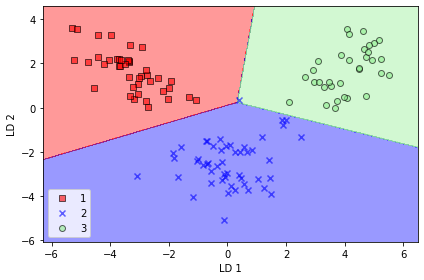

In [16]:
# 사이킷런에서 구현된 LDA

# 결졍 경계 표시하기 위한 함수
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap.colors[idx],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
        
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()